# Overview

**Full Training (Accuracy Measurements)**

Based on the timing results from the previous notebook, we focus on the two most promising combinations:

1. Pure Dice Loss
2. PyDTs HD Loss + Dice Loss (proposed method)

We run a full training session for each combination, using 600 epochs and evaluating the model on the validation set every 30 epochs. We measure Dice score, Hausdorff distance, and 95th percentile Hausdorff distance.

For each combination, we save the best model based on the validation Dice score, load it, evaluate it using all metrics, and visualize the ground truth label, predicted segmentation, and their boundaries for a validation sample and save all these data points as .csv and .png files.

By comparing the accuracy results, we aim to demonstrate the benefits of incorporating the Hausdorff distance as a loss function.

We use MONAI for data loading, preprocessing, model definition, and evaluation metrics, and `py_distance_transforms` for efficient GPU-based Hausdorff distance computation.

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install py_distance_transforms
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.4/397.4 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)

**NOTE**: *First time importing `py_distance_transforms` might take a while (~up to 8 mins)*

In [ ]:
from py_distance_transforms import transform_cuda
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, HausdorffDistanceMetric, compute_percent_hausdorff_distance, compute_iou, MeanIoU
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F
import numpy as np
import time
import timeit
import pandas as pd

from juliacall import Main as jl
jl.seval("import CUDA")

# print_config()

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/py_distance_transforms/juliapkg.json
[juliapkg] Locating Julia ~1.9, =1.10.0, ~1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.4 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.4-linux-x86_64.tar.gz
             download complete
[julia

2024-07-05 21:42:05.801036: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 21:42:05.852770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 21:42:05.852827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 21:42:05.854355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 21:42:05.862237: I tensorflow/core/platform/cpu_feature_guar

**Setup data directory**

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvs79eojg


**Download dataset**

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:20, 20.0MB/s]                            

2024-07-05 21:43:28,851 - INFO - Downloaded: /tmp/tmpvs79eojg/Task09_Spleen.tar


2024-07-05 21:43:31,896 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-07-05 21:43:31,897 - INFO - Writing into directory: /tmp/tmpvs79eojg.


**Set MSD Spleen dataset path**

In [ ]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

**Set deterministic training for reproducibility**

In [ ]:
set_determinism(seed=0)

**Setup transforms for training and validation**

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        )
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check setup in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


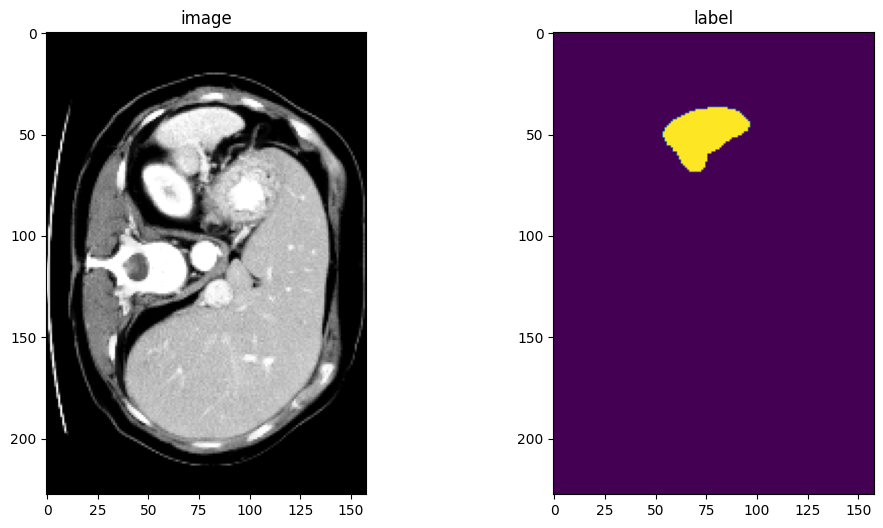

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## CacheDataset

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


# Full Training (Accuracy Measurements)

Let's focus on the two fastest, pure dice loss and dice loss + pydt hausdorff loss, and run a full training. The combination of hd loss plus dice should be more powerful than pure dice. But, this needs to be tested fully. Let's look at just these two and run for 600 epochs, then lets save the best model and metrics. Finally we will visualize the ground truth label and the prediction and their boundaries, for each model

## Pure Dice Loss (Gold Standard)

In [ ]:
data_path_dir = f"/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data"

In [ ]:
# Create metric objects
dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=False, reduction="mean")
hausdorff_95_metric = HausdorffDistanceMetric(include_background=False, percentile=95, reduction="mean")
iou_metric = MeanIoU(include_background=False, reduction="mean")

In [ ]:
dice_loss = DiceLoss(to_onehot_y=True, softmax=True)

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
max_epochs = 200
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

start_time = time.time()
for epoch in range(max_epochs):
  print("-" * 10)
  print(f"epoch {epoch + 1}/{max_epochs}")
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = (
          batch_data["image"].to(device),
          batch_data["label"].to(device),
      )
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = dice_loss(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
      model.eval()
      with torch.no_grad():
          for val_data in val_loader:
              val_inputs, val_labels = (
                  val_data["image"].to(device),
                  val_data["label"].to(device),
              )
              roi_size = (160, 160, 160)
              sw_batch_size = 4
              val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
              val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
              val_labels = [post_label(i) for i in decollate_batch(val_labels)]
              # compute metric for current iteration
              dice_metric(y_pred=val_outputs, y=val_labels)

          # aggregate the final mean dice result
          metric = dice_metric.aggregate().item()
          # reset the status for next validation round
          dice_metric.reset()

          metric_values.append(metric)
          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              torch.save(model.state_dict(), os.path.join(data_path_dir, "best_metric_model_dice.pth"))
              print("saved new best metric model")
          print(
              f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
              f"\nbest mean dice: {best_metric:.4f} "
              f"at epoch: {best_metric_epoch}"
          )
  scheduler.step()

end_time = time.time()
total_time = end_time - start_time

----------
epoch 1/200


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/16, train_loss: 0.6116
2/16, train_loss: 0.6028
3/16, train_loss: 0.6211
4/16, train_loss: 0.6159
5/16, train_loss: 0.5892
6/16, train_loss: 0.6239
7/16, train_loss: 0.6188
8/16, train_loss: 0.5835
9/16, train_loss: 0.5943
10/16, train_loss: 0.5944
11/16, train_loss: 0.6049
12/16, train_loss: 0.5785
13/16, train_loss: 0.5848
14/16, train_loss: 0.5705
15/16, train_loss: 0.5718
16/16, train_loss: 0.5601
epoch 1 average loss: 0.5954
----------
epoch 2/200
1/16, train_loss: 0.5552
2/16, train_loss: 0.5777
3/16, train_loss: 0.5545
4/16, train_loss: 0.5343
5/16, train_loss: 0.5442
6/16, train_loss: 0.5290
7/16, train_loss: 0.5322
8/16, train_loss: 0.5418
9/16, train_loss: 0.5100
10/16, train_loss: 0.5287
11/16, train_loss: 0.5074
12/16, train_loss: 0.4786
13/16, train_loss: 0.5153
14/16, train_loss: 0.4969
15/16, train_loss: 0.5106
16/16, train_loss: 0.5262
epoch 2 average loss: 0.5277
saved new best metric model
current epoch: 2 current mean dice: 0.0733
best mean dice: 0.0733 at epoch: 2

KeyboardInterrupt: 

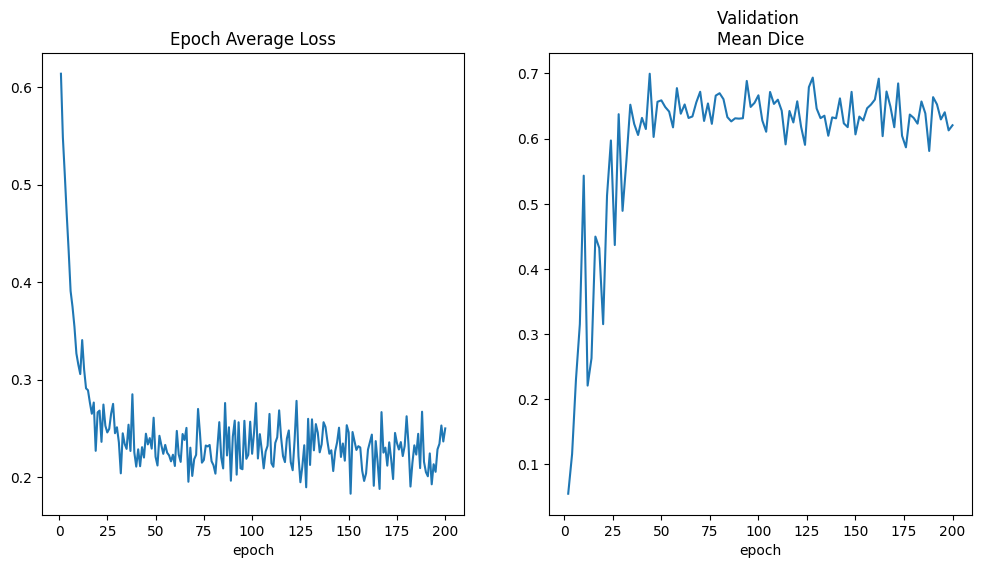

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation \nMean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
# Save the training results as a DataFrame/CSV
df = pd.DataFrame({
    'Training Loss': epoch_loss_values,
    'Validation Dice Score': [metric_values[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
})

# Fill NaN values in 'Validation Dice Score' columns with previous values
df['Validation Dice Score'] = df['Validation Dice Score'].fillna(method='ffill')

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "training_results_dice.csv")
df.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

Training completed. Results saved as '/content/drive/MyDrive/dev/MolloiLab/distance-transforms-paper/data/training_results_dice.csv'


In [ ]:
# Load the saved best model
best_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_dice.pth")))

# Evaluate the best model on the validation set using all metrics
best_model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, best_model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Compute metrics for the best model
        dice_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_95_metric(y_pred=val_outputs, y=val_labels)
        iou_metric(y_pred=val_outputs, y=val_labels)

    # Aggregate the final metric results for the best model
    dice_score = dice_metric.aggregate().item()
    hausdorff_distance = hausdorff_metric.aggregate().item()
    hausdorff_distance_95 = hausdorff_95_metric.aggregate().item()
    iou_score = iou_metric.aggregate().item()

In [ ]:
# Initialize an empty list to store the model's details and metrics
model_data = []

# Append the best model's details and metrics to the list
model_data.append({
    'Model': 'Dice Loss',
    'Best Epoch': best_metric_epoch,
    'Dice Score': dice_score,
    'Hausdorff Distance': hausdorff_distance,
    '95 Percentile Hausdorff Distance': hausdorff_distance_95,
    'IoU Score': iou_score,
    'Total Training Time (s)': total_time
})

# Create a DataFrame from the model_data list
df_plain_dice = pd.DataFrame(model_data)

# Save the DataFrame as a CSV file
df_dice_path = os.path.join(data_path_dir, "hd_loss_metrics_dice.csv")
df_plain_dice.to_csv(df_dice_path)

In [ ]:
df_plain_dice

,Model,Best Epoch,Dice Score,Hausdorff Distance,95 Percentile Hausdorff Distance,IoU Score,Total Training Time (s)
0,Dice Loss,44,0.699537,170.594025,133.600922,0.5615,1289.829225


In [ ]:
torch.cuda.empty_cache()

## PyDTs HD Loss + Dice Loss (Proposed)

In [ ]:
def compute_dtm_gpu(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, x, y, z)
    output: the foreground Distance Map (SDM)
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    # Convert img_gt to float if not already float
    if img_gt.dtype != torch.float32:
        img_gt = img_gt.float()

    fg_dtm = torch.zeros(out_shape, dtype=torch.float32, device=img_gt.device)

    for b in range(out_shape[0]):  # batch size
        for c in range(1, out_shape[1]):
            posmask = img_gt[b]
            if posmask.bool().any():
                posdis = transform_cuda(posmask)
                fg_dtm[b, c] = posdis

    return fg_dtm.to(img_gt.dtype)

In [ ]:
def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,2,x,y,z)
    output: boundary_loss; sclar
    """

    delta_s = (seg_soft[:,1,...] - gt.float()) ** 2
    s_dtm = seg_dtm[:,1,...] ** 2
    g_dtm = gt_dtm[:,1,...] ** 2
    dtm = s_dtm + g_dtm

    multipled = torch.einsum('bxyz, bxyz->bxyz', delta_s, dtm)
    hd_loss = multipled.mean()

    return hd_loss

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model_hd_dice = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

optimizer = torch.optim.SGD(model_hd_dice.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
max_epochs = 200
val_interval = 2
best_metric_hd_pydt = -1
best_metric_epoch_hd_pydt = -1
epoch_loss_values_hd_pydt = []
metric_values_hd_pydt = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

alpha = 1.0 # Define alpha for the combined loss
start_time_hd_pydt = time.time()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model_hd_dice.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model_hd_dice(inputs)
        ## --- Loss Function --- ##
        loss_seg_dice = dice_loss(outputs, labels)
        outputs_soft = F.softmax(outputs, dim=1)

        with torch.no_grad():
            gt_dtm = compute_dtm_gpu(labels, outputs_soft.shape)
            seg_dtm = compute_dtm_gpu(outputs_soft[:, 1, :, :, :] > 0.5, outputs_soft.shape)

        loss_hd = hd_loss(outputs_soft, labels[:, 0, :, :, :], seg_dtm, gt_dtm)
        loss = alpha * loss_seg_dice + (1 - alpha) * loss_hd
        ## --- Loss Function --- ##
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values_hd_pydt.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model_hd_dice.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model_hd_dice)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values_hd_pydt.append(metric)
            if metric > best_metric_hd_pydt:
                best_metric_hd_pydt = metric
                best_metric_epoch_hd_pydt = epoch + 1
                torch.save(model_hd_dice.state_dict(), os.path.join(data_path_dir, "best_metric_model_hd_dice.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric_hd_pydt:.4f} "
                f"at epoch: {best_metric_epoch_hd_pydt}"
            )
    alpha -= 0.01
    if alpha <= 0.001:
        alpha = 0.001
    scheduler.step()

    jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM overflows, not a huge slowdown penalty either

end_time_hd_pydt = time.time()
total_time_hd_pydt = end_time_hd_pydt - start_time_hd_pydt

----------
epoch 1/200


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/16, train_loss: 0.6304
2/16, train_loss: 0.5663
3/16, train_loss: 0.5976
4/16, train_loss: 0.6076
5/16, train_loss: 0.5723
6/16, train_loss: 0.6211
7/16, train_loss: 0.5609
8/16, train_loss: 0.5448
9/16, train_loss: 0.5658
10/16, train_loss: 0.5200
11/16, train_loss: 0.5866
12/16, train_loss: 0.5309
13/16, train_loss: 0.5531
14/16, train_loss: 0.5561
15/16, train_loss: 0.5568
16/16, train_loss: 0.5289
epoch 1 average loss: 0.5687
----------
epoch 2/200
1/16, train_loss: 2.3723
2/16, train_loss: 0.9097
3/16, train_loss: 0.7064
4/16, train_loss: 0.9064
5/16, train_loss: 1.0924
6/16, train_loss: 0.8285
7/16, train_loss: 0.6025
8/16, train_loss: 0.6231
9/16, train_loss: 0.6017
10/16, train_loss: 0.5843
11/16, train_loss: 1.0069
12/16, train_loss: 0.6801
13/16, train_loss: 1.2543
14/16, train_loss: 1.1987
15/16, train_loss: 0.6713
16/16, train_loss: 0.9791
epoch 2 average loss: 0.9386
saved new best metric model
current epoch: 2 current mean dice: 0.3716
best mean dice: 0.3716 at epoch: 2

KeyboardInterrupt: 

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values_hd_pydt))]
y = epoch_loss_values_hd_pydt
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation \nMean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values_hd_pydt))]
y = metric_values_hd_pydt
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
jl.seval("CUDA.GC.gc(true); CUDA.reclaim()") # IMPORTANT, otherwise GPU RAM overflows, not a huge slowdown penalty either
torch.cuda.empty_cache()

In [ ]:
# Save the training results as a DataFrame/CSV
df_hd_pydt = pd.DataFrame({
    'Training Loss': epoch_loss_values_hd_pydt,
    'Validation Dice Score': [metric_values_hd_pydt[i // val_interval] if i % val_interval == 0 else None for i in range(max_epochs)],
})

# Fill NaN values in 'Validation Dice Score' columns with previous values
df_hd_pydt['Validation Dice Score'] = df_hd_pydt['Validation Dice Score'].fillna(method='ffill')

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "training_results_hd_pydt.csv")
df_hd_pydt.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

In [ ]:
# Load the saved best model
best_model_hd_pydt = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
best_model_hd_pydt.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_hd_pydt.pth")))

# Evaluate the best model on the validation set using all metrics
best_model_hd_pydt.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, best_model_hd_pydt)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Compute metrics for the best model
        dice_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_metric(y_pred=val_outputs, y=val_labels)
        hausdorff_95_metric(y_pred=val_outputs, y=val_labels)
        iou_metric(y_pred=val_outputs, y=val_labels)

    # Aggregate the final metric results for the best model
    dice_score = dice_metric.aggregate().item()
    hausdorff_distance = hausdorff_metric.aggregate().item()
    hausdorff_distance_95 = hausdorff_95_metric.aggregate().item()
    iou_score = iou_metric.aggregate().item()

# Append the best model's details and metrics to the list
model_data_hd_pydt = []
model_data_hd_pydt.append({
    'Model': 'HD Loss + Dice Loss',
    'Best Epoch': best_metric_epoch_hd_pydt,
    'Dice Score': dice_score,
    'Hausdorff Distance': hausdorff_distance,
    '95 Percentile Hausdorff Distance': hausdorff_distance_95,
    'IoU Score': iou_score,
    'Total Training Time (s)': total_time_hd_pydt,
})

# Create a DataFrame from the model_data list
df_hd_dice = pd.DataFrame(model_data_hd_pydt)

# Save the DataFrame as a CSV file
csv_path = os.path.join(data_path_dir, "hd_loss_metrics_hd_pydt.csv")
df_hd_dice.to_csv(csv_path, index=False)

print(f"Training completed. Results saved as '{csv_path}'")

In [ ]:
df_hd_dice

## Qualitative Comparison

In [ ]:
# # Load the best models
# best_model_dice = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
# best_model_dice.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_dice.pth")))

# best_model_hd_dice = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     norm=Norm.BATCH,
# ).to(device)
# best_model_hd_dice.load_state_dict(torch.load(os.path.join(data_path_dir, "best_metric_model_hd_pydt.pth")))

# # Set the models to evaluation mode
# best_model_dice.eval()
# best_model_hd_dice.eval();

In [ ]:
# import os

# # Specify the desired slices
# slice_nums = [66, 67, 69, 88, 89, 90]

# # Create a directory to save the images
# output_dir = os.path.join(data_path_dir, "slice_images")
# os.makedirs(output_dir, exist_ok=True)

# with torch.no_grad():
#     for i, val_data in enumerate(val_loader):
#         if i == 3:
#             break

#         # Get the input image and label
#         image = val_data["image"].to(device)
#         label = val_data["label"].to(device)

#         roi_size = (160, 160, 160)
#         sw_batch_size = 4

#         # Get the model outputs
#         output_dice = sliding_window_inference(image, roi_size, sw_batch_size, best_model_dice)
#         output_hd_dice = sliding_window_inference(image, roi_size, sw_batch_size, best_model_hd_dice)

#         for slice_num in slice_nums:
#             # Convert the outputs to binary masks
#             mask_dice = torch.argmax(output_dice, dim=1).detach().cpu().numpy()[0, :, :, slice_num]
#             mask_hd_dice = torch.argmax(output_hd_dice, dim=1).detach().cpu().numpy()[0, :, :, slice_num]

#             # Convert the label to a binary mask
#             label_mask = label.detach().cpu().numpy()[0, 0, :, :, slice_num]

#             # Create a figure without axes
#             fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
#             ax.axis('off')

#             # Display the input image
#             ax.imshow(image.detach().cpu().numpy()[0, 0, :, :, slice_num], cmap="gray", interpolation='lanczos')  # Apply interpolation

#             # Save the input image
#             plt.savefig(os.path.join(output_dir, f"input_image_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
#             plt.close(fig)

#             # Create a figure without axes
#             fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
#             ax.axis('off')

#             # Display the label mask
#             ax.imshow(label_mask, cmap="gray", interpolation='lanczos')  # Apply interpolation

#             # Save the label mask
#             plt.savefig(os.path.join(output_dir, f"label_mask_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
#             plt.close(fig)

#             # Create a figure without axes
#             fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size
#             ax.axis('off')

#             # Display the label mask with predicted contours
#             ax.imshow(label_mask, cmap="gray", interpolation='lanczos')  # Apply interpolation
#             ax.contour(mask_hd_dice, colors="green", linewidths=1)
#             ax.contour(mask_dice, colors="red", linewidths=1, linestyles=':')

#             # Save the label mask with predicted contours
#             plt.savefig(os.path.join(output_dir, f"predictions_{i+1}_slice_{slice_num}.png"), dpi=600, bbox_inches='tight', pad_inches=0)  # Increase dpi
#             plt.close(fig)